## Classification of Seismic Events Using Unsupervised Machine Learning
### Data Preparation Section
#### By Jeff Church (churchjm@umich.edu), Dongdong Yao (dongdony@umich.edu), and Yihe Huang (yiheh@umich.edu)

This notebook prepares two datasets retrieved from the [TA:O53A](http://ds.iris.edu/mda/TA/O53A/?starttime=2012-12-13T00:00:00&endtime=2018-09-27T23:59:59) seismograph station located in New Philadelphia, OH.  The first is a labeled dataset containing 1,251 induced earthquakes and 5,152 mining blasts recorded between 2013-2018.  The second dataset is comprised of 7,398 unlabeled events automatically "picked" by the [PhaseNet](https://arxiv.org/abs/1803.03211) tool.  The PhaseNet dataset spans 2013-2016.

STFT spectrograms are also computed for each event in both datasets.

Onset times of labeled events are stored in the blasts.list and inducedEQ.list files.  PhaseNet picks are already downloaded and stored in .SAC files.  These three files are the "starting point" of the project.

**All data files used by this notebook can be downloaded [here](https://drive.google.com/drive/folders/1-Eex84NC7S8D0qj-rliZ34Xw5-PKQuaS?usp=sharing).**

# Functions and Settings

In [ ]:
# NOTE: If running this notebook in Google Colab, the runtime must be restarted after installing obspy to avoid errors.
!pip install obspy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
from scipy import signal

import obspy
from obspy import read
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

import matplotlib.pyplot as plt

In [ ]:
ROOT_PATH = r'/content/drive/Shared drives/Capstone/Data'

LABELED_PATH = f'{ROOT_PATH}/Labeled EQ and Blasts'
PHASENET_PATH = f'{ROOT_PATH}/PhaseNet Picks'

SAMPLE_RATE = 100.0

client = Client('IRIS')

In [ ]:
f_blast = open(LABELED_PATH + r'/blasts.list', 'r')
lines_blast = f_blast.readlines()

dts_blast = []
for line in lines_blast:
  dts_blast.append(UTCDateTime(line[:-1]))

f_blast.close()

f_eq = open(LABELED_PATH + r'/inducedEQ.list', 'r')
lines_eq = f_eq.readlines()

dts_eq = []
for line in lines_eq:
  dts_eq.append(UTCDateTime(line[:-1]))

f_eq.close()

In [ ]:
def download_waveforms(dts):
  wforms = []
  wforms_downsample = []
  timestamps = []

  i = 0
  for dt in dts:
    try:
      st_raw = client.get_waveforms(network='TA',station='O53A',location='--',channel='BH?',
                                  starttime=dt,endtime=dt+30,attach_response=True)

      pre_filt = (0.01,0.02,18,20) 
      st_raw.remove_response(pre_filt=pre_filt, output='VEL')
      
      st_downsample = st_raw.copy()
      st_downsample.filter('highpass', freq=1.0)
      st_downsample.decimate(2) # 20Hz for d3.js tooltip chart (to keep .json file small)

      st = st_raw.copy()
      st.interpolate(sampling_rate=SAMPLE_RATE)
      st.filter('bandpass', freqmin=1.0, freqmax=20.0, corners=2, zerophase=True)

      E = st[0].data
      if len(E) != 3001:
        num_zeros = 3001-len(E)
        E = np.append(E, np.zeros((1,num_zeros), dtype=E.dtype))
      
      E_downsample = st_downsample[0].data
      if len(E_downsample) != 601:
        num_zeros = 601-len(E_downsample)
        E_downsample = np.append(E_downsample, np.zeros((1,num_zeros), dtype=E_downsample.dtype))

      N = st[1].data
      if len(N) != 3001:
        num_zeros = 3001-len(N)
        N = np.append(N, np.zeros((1,num_zeros), dtype=N.dtype))
      
      N_downsample = st_downsample[1].data
      if len(N_downsample) != 601:
        num_zeros = 601-len(N_downsample)
        N_downsample = np.append(N_downsample, np.zeros((1,num_zeros), dtype=N_downsample.dtype))

      Z = st[2].data
      if len(Z) != 3001:
        num_zeros = 3001-len(Z)
        Z = np.append(Z, np.zeros((1,num_zeros), dtype=Z.dtype))
      
      Z_downsample = st_downsample[2].data
      if len(Z_downsample) != 601:
        num_zeros = 601-len(Z_downsample)
        Z_downsample = np.append(Z_downsample, np.zeros((1,num_zeros), dtype=Z_downsample.dtype))

      wforms.append(np.asarray([E, N, Z]))
      wforms_downsample.append(np.asarray([E_downsample, N_downsample, Z_downsample]))
      timestamps.append(st[0].times(type="timestamp")[0])

      i += 1
      if i%100==0:
        print(f'{i} events downloaded.')
    except Exception as ex:
      print(ex)

  wforms_arr = np.asarray(wforms)
  wforms_downsample_arr = np.asarray(wforms_downsample)
  timestamps_arr = np.asarray(timestamps)

  return (wforms_arr, wforms_downsample_arr, timestamps_arr)


In [ ]:
def compute_stft_spectrograms(wforms):
  max = 0.0
  spectrograms = []

  for wform in wforms:
    Z = wform[2,:]
    Z = Z/np.max(Z)
    f, t, Zxx = signal.stft(Z, fs = 100.0, nperseg=94) # These params produce spectrogram of shape 16x48, as required by Mousavi's model
    spec = np.abs(Zxx)
    spec = spec[:, :-1]

    spec_max = np.amax(spec)
    if spec_max > max:
      max = spec_max

    if spec.shape != (48,64):
      print(f'ERROR. Spectrogram shape {spec.shape} incorrect.')
    spectrograms.append(spec)

  spectrograms_arr = np.asarray(spectrograms)
  spectrograms_arr = spectrograms_arr/max # normalize spectrograms by max value in data set, as recommended by Dr. Mousavi

  return spectrograms_arr

# Effects of pre-filtering and bandpass filtering data retrieved from obspy

In [ ]:
# dt_sampleday_start = UTCDateTime(2013,9,9)
# dt_sampleday_end = UTCDateTime(2013,9,10)

# dt_sampleshort_start = UTCDateTime(2013,9,9,12,35,0)
# dt_sampleshort_end = UTCDateTime(2013,9,9,12,35,15)

# st_sampleday_raw = client.get_waveforms(network='TA',station='O53A',location='--',channel='BH?',
#                                   starttime=dt_sampleday_start,endtime=dt_sampleday_end,attach_response=True)

# st_sampleshort_raw = client.get_waveforms(network='TA',station='O53A',location='--',channel='BH?',
#                                   starttime=dt_sampleshort_start,endtime=dt_sampleshort_end,attach_response=True)

# pre_filt = (0.01,0.02,18,20)

In [ ]:
# fig = plt.figure(figsize=(10,10))
# plt.title('Effects of Signal Filtering')

# fig.text(0.51, 0.255, 'Pre-filtering and bandpass filter', ha='center', fontsize=12)
# fig.text(0.51, 0.415, 'Pre-filtering only', ha='center', fontsize=12)
# fig.text(0.51, 0.575, 'Bandpass filtering only', ha='center', fontsize=12)
# fig.text(0.51, 0.74, 'Response Removed (no filters)', ha='center', fontsize=12)
# fig.text(0.51, 0.895, 'Raw data (no response removal)', ha='center', fontsize=12)

# ax1 = plt.subplot(521)
# ax1.axes.xaxis.set_visible(False)
# ax2 = plt.subplot(522)
# ax2.axes.xaxis.set_visible(False)
# ax3 = plt.subplot(523)
# ax3.axes.xaxis.set_visible(False)
# ax4 = plt.subplot(524)
# ax4.axes.xaxis.set_visible(False)
# ax5 = plt.subplot(525)
# ax5.axes.xaxis.set_visible(False)
# ax6 = plt.subplot(526)
# ax6.axes.xaxis.set_visible(False)
# ax7 = plt.subplot(527)
# ax7.axes.xaxis.set_visible(False)
# ax8 = plt.subplot(528)
# ax8.axes.xaxis.set_visible(False)
# ax9 = plt.subplot(529)
# ax9.axes.xaxis.set_visible(False)
# ax10 = plt.subplot(5,2,10)
# ax10.axes.xaxis.set_visible(False)

# # Raw signal (response not removed)
# ax1.plot(st_sampleday_raw[2].times(), st_sampleday_raw[2].data)
# ax2.plot(st_sampleshort_raw[2].times(), st_sampleshort_raw[2].data)

# # No pre-filtering or bandpass (response removed)
# orig_day = st_sampleday_raw.copy()
# orig_day.remove_response(output='VEL')
# orig_short = st_sampleshort_raw.copy()
# orig_short.remove_response(output='VEL')

# ax3.plot(orig_day[2].times(), orig_day[2].data)
# ax4.plot(orig_short[2].times(), orig_short[2].data)

# # Bandpass filter only -- removes low freq artifacts
# bandpass_day = st_sampleday_raw.copy()
# bandpass_day.remove_response(output='VEL')
# bandpass_day.interpolate(sampling_rate=SAMPLE_RATE)
# bandpass_day.filter('bandpass', freqmin=1.0, freqmax=20.0, corners=2, zerophase=True)

# bandpass_short = st_sampleshort_raw.copy()
# bandpass_short.remove_response(output='VEL')
# bandpass_short.interpolate(sampling_rate=SAMPLE_RATE)
# bandpass_short.filter('bandpass', freqmin=1.0, freqmax=20.0, corners=2, zerophase=True)

# ax5.plot(bandpass_day[2].times(), bandpass_day[2].data)
# ax6.plot(bandpass_short[2].times(), bandpass_short[2].data)

# # pre-filt only
# prefilt_day = st_sampleday_raw.copy()
# prefilt_day.remove_response(pre_filt=pre_filt, output='VEL')
# prefilt_short = st_sampleshort_raw.copy()
# prefilt_short.remove_response(pre_filt=pre_filt, output='VEL')

# ax7.plot(prefilt_day[2].times(), prefilt_day[2].data)
# ax8.plot(prefilt_short[2].times(), prefilt_short[2].data)

# # pre-filt and bandpass
# both_day = st_sampleday_raw.copy()
# both_day.remove_response(pre_filt=pre_filt, output='VEL')
# both_day.interpolate(sampling_rate=SAMPLE_RATE)
# both_day.filter('bandpass', freqmin=1.0, freqmax=20.0, corners=2, zerophase=True)
# both_short = st_sampleshort_raw.copy()
# both_short.remove_response(pre_filt=pre_filt, output='VEL')
# both_short.interpolate(sampling_rate=SAMPLE_RATE)
# both_short.filter('bandpass', freqmin=1.0, freqmax=20.0, corners=2, zerophase=True)

# ax9.plot(both_day[2].times(), both_day[2].data)
# ax10.plot(both_short[2].times(), both_short[2].data)

# plt.subplots_adjust(hspace=0.5);
# plt.subplots_adjust(wspace=0.1)

# Load Labeled Dataset

In [ ]:
if not os.path.exists(f'{LABELED_PATH}/wforms_blast.npy'):
  print('Saved .npy not found.  Downloading data...')
  wforms_blast, wforms_blast_downsample, timestamps_blast = download_waveforms(dts_blast)
  np.save(f'{LABELED_PATH}/wforms_blast', wforms_blast)
  np.save(f'{LABELED_PATH}/wforms_blast_downsample', wforms_blast_downsample)
  np.save(f'{LABELED_PATH}/timestamps_blast', timestamps_blast)
else:
  print('Loading saved .npy')
  wforms_blast = np.load(f'{LABELED_PATH}/wforms_blast.npy')
  wforms_blast_downsample = np.load(f'{LABELED_PATH}/wforms_blast_downsample.npy')
  timestamps_blast = np.load(f'{LABELED_PATH}/timestamps_blast.npy')

print(wforms_blast.shape)
print(wforms_blast_downsample.shape)
print(timestamps_blast.shape)

Loading saved .npy
(5152, 3, 3001)
(5152, 3, 601)
(5152,)


In [ ]:
if not os.path.exists(f'{LABELED_PATH}/wforms_eq.npy'):
  print('Saved .npy not found.  Downloading data...')
  wforms_eq, wforms_eq_downsample, timestamps_eq = download_waveforms(dts_eq)
  np.save(f'{LABELED_PATH}/wforms_eq', wforms_eq)
  np.save(f'{LABELED_PATH}/wforms_eq_downsample', wforms_eq_downsample)
  np.save(f'{LABELED_PATH}/timestamps_eq', timestamps_eq)
else:
  print('Loading saved .npy')
  wforms_eq = np.load(f'{LABELED_PATH}/wforms_eq.npy')
  wforms_eq_downsample = np.load(f'{LABELED_PATH}/wforms_eq_downsample.npy')
  timestamps_eq = np.load(f'{LABELED_PATH}/timestamps_eq.npy')

print(wforms_eq.shape)
print(wforms_eq_downsample.shape)
print(timestamps_eq.shape)

Loading saved .npy
(1251, 3, 3001)
(1251, 3, 601)
(1251,)


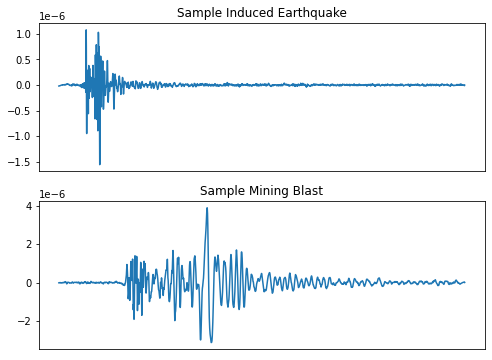

In [ ]:
fig = plt.figure(figsize=(8,6))

ax1 = plt.subplot(211)
ax1.axes.xaxis.set_visible(False)
ax2 = plt.subplot(212)
ax2.axes.xaxis.set_visible(False)

sample_eq = wforms_eq[500,2,:]
ax1.plot(sample_eq)
ax1.title.set_text('Sample Induced Earthquake')

sample_blast = wforms_blast[500,2,:]
ax2.plot(sample_blast)
ax2.title.set_text('Sample Mining Blast');

In [ ]:
if not os.path.exists(f'{LABELED_PATH}/spectrograms_blast.npy'):
  print('Saved .npy not found.  Computing spectrograms...')
  spectrograms_blast = compute_stft_spectrograms(wforms_blast)
  np.save(f'{LABELED_PATH}/spectrograms_blast', spectrograms_blast)
else:
  print('Loading saved .npy')
  spectrograms_blast = np.load(f'{LABELED_PATH}/spectrograms_blast.npy')

print(spectrograms_blast.shape)

if not os.path.exists(f'{LABELED_PATH}/spectrograms_eq.npy'):
  print('Saved .npy not found.  Computing spectrograms...')
  spectrograms_eq = compute_stft_spectrograms(wforms_eq)
  np.save(f'{LABELED_PATH}/spectrograms_eq', spectrograms_eq)
else:
  print('Loading saved .npy')
  spectrograms_eq = np.load(f'{LABELED_PATH}/spectrograms_eq.npy')

print(spectrograms_eq.shape)

Loading saved .npy
(5152, 48, 64)
Loading saved .npy
(1251, 48, 64)


# Load PhaseNet Dataset

For the following code to work in the absense of the saved .npy files.  The four *.tar.gz files in the data folder must be extracted first.

In [ ]:
if not os.path.exists(f'{PHASENET_PATH}/wforms_phasenet.npy'):
  folders = [name for name in os.listdir(PHASENET_PATH) if not (name.endswith('.tar.gz') or name.endswith('.npy'))]
  print(f'Number of events: {len(folders)}.  Should be 7,398.')

  wforms = []
  wforms_downsample = []
  timestamps = []

  i = 0
  for folder in folders:
    data = {}
    for filename in os.listdir(PHASENET_PATH + f'/{folder}'):
      st = read(PHASENET_PATH + f'/{folder}/{filename}')
      st.filter('bandpass', freqmin=1.0, freqmax=20.0, corners=2, zerophase=True)
      channel = filename[-5]
      data[channel] = st[0].data

      st_downsample = st.copy()
      st_downsample.decimate(5) # Again, 20Hz to keep visualization .json file from getting too large
      data[f'{channel}_downsample'] = st_downsample[0].data

      if channel == 'E':
        timestamps.append(st[0].times(type='timestamp')[0])

    wforms.append(np.asarray([data['E'], data['N'], data['Z']]))
    wforms_downsample.append(np.asarray([data['E_downsample'], data['N_downsample'], data['Z_downsample']]))

    i += 1
    if i%100==0:
      print(f'{i} events loaded.')

  print('Done loading.')

  wforms_arr = np.asarray(wforms)
  wforms_downsample_arr = np.asarray(wforms_downsample)
  timestamps_arr = np.asarray(timestamps)

  np.save(f'{PHASENET_PATH}/wforms_phasenet', wforms_arr)
  np.save(f'{PHASENET_PATH}/wforms_phasenet_downsample', wforms_downsample_arr)
  np.save(f'{PHASENET_PATH}/timestamps_phasenet', timestamps_arr)
else:
  wforms_arr = np.load(f'{PHASENET_PATH}/wforms_phasenet.npy')
  wforms_downsample_arr = np.load(f'{PHASENET_PATH}/wforms_phasenet_downsample.npy')
  timestamps_arr = np.load(f'{PHASENET_PATH}/timestamps_phasenet.npy')

print(wforms_arr.shape)
print(wforms_downsample_arr.shape)
print(timestamps_arr.shape)

(7398, 3, 3001)
(7398, 3, 601)
(7398,)


In [ ]:
if not os.path.exists(f'{PHASENET_PATH}/spectrograms_phasenet.npy'):
  print('Saved .npy not found.  Computing spectrograms...')
  spectrograms_phasenet = compute_stft_spectrograms(wforms_arr)
  np.save(f'{PHASENET_PATH}/spectrograms_phasenet', spectrograms_phasenet)
else:
  print('Loading saved .npy')
  spectrograms_phasenet = np.load(f'{PHASENET_PATH}/spectrograms_phasenet.npy')

print(spectrograms_phasenet.shape)

Loading saved .npy
(7398, 48, 64)
